# Importing necesary packages
We primarily use pytorch 

In [ ]:
%matplotlib.inline

In [ ]:
from __future__ import print_function
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import random
import argparse

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from IPython.display import HTML



# Set up random seed 

In [ ]:
Random_Seed = 999
random.seed(Random_Seed)
torch.manual_seed(Random_Seed) 

# Load data set from Kaggle
Download the data set as a zip file, using designated kaggle user name and password.

In [ ]:
#os.environ['KAGGLE_USERNAME'] = "jatinmenta" # username from the json file 
#os.environ['KAGGLE_KEY'] = "a37ab87976d7c098ebfd24d662ff99c6" # key from the json file
#! kaggle datasets download -d vishalsubbiah/pokemon-images-and-types


os.environ['KAGGLE_USERNAME'] = "anikabxy88" # username from the json file 
os.environ['KAGGLE_KEY'] = "03cef0600840290768574c0d2aa80964" # key from the json file
! kaggle datasets download -d anikabxy88/pokedexgen8

100% 5.94M/5.94M [00:00<00:00, 10.1MB/s]
100% 5.94M/5.94M [00:00<00:00, 10.7MB/s]


# Extract data and preliminary analysis
Extract all files from the downloaded zip file

In [ ]:
import zipfile
zip = zipfile.ZipFile('pokedexgen8.zip')
zip.extractall()

In [ ]:
# Number of workers for dataloader
workers = 4

# Batch size for training
batch_size = 128

# Training image size. All images will be resized to 64x64
image_size = 64

# Number of channels, for RGB,number is 3
nc = 3

# Size of z, the latent vector (generator input size)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 30000

# Learning rate for Adam
lr = 0.0002

# Beta1 hyperparam for Adam 
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu =1

# Creat data set for training 
use the image folder data set we loaded,
use tecniques of resize, normalize and augment the size of data for GAN traning

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transp

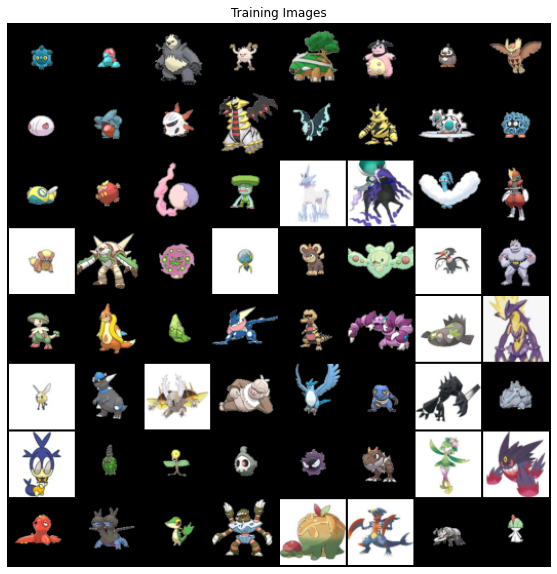

In [16]:
dataroot = "image"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Establish device, GPU is highly recommended for faster training; CPU took more than 2 hours
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some example training images from our data set
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))




# Model building 
First we initialize the weights, using normal distribution of mean = 0, standard deviation = 0.02

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, mean = 0.0, std = 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, mean = 1.0, std = 0.02)
        nn.init.constant_(m.bias.data, val = 0)

In [ ]:
#Generator

class Generator(nn.Module):
    def __init__(self,ngpu):
        super(Generator,self).__init__()

        self.ngpu = ngpu

        self.main = nn.Sequential(
            
            # Input: latent vector Z, ngf is num of frasure map in generator
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4,stride = 1,padding = 0, bias = False),
            nn.BatchNorm2d(num_features = ngf * 8),
            nn.ReLU(True),

            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding =1, bias=False),
            nn.BatchNorm2d(num_features = ngf * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels= ngf * 4, out_channels= ngf * 2,kernel_size= 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(num_features = ngf * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels= ngf * 2,out_channels= ngf,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(num_features = ngf),
            nn.ReLU(True),

            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels= ngf,out_channels= nc,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)                 

# Set up generator

In [ ]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Initialize weights randomly, mean = 0, std = 0.2
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator 
ndf is size of fearure maps in discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        
        super(Discriminator,self).__init__()

        self.ngpu = ngpu

        self.main = nn.Sequential(
           # input size: (nc) x 64 x 64
            nn.Conv2d(in_channels = nc,out_channels= ndf,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf) x 32 x 32
            nn.Conv2d(in_channels = ndf,out_channels= ndf * 2,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(num_features = ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*2) x 16 x 16
            nn.Conv2d(in_channels = ndf * 2,out_channels= ndf * 4,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(num_features = ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*4) x 8 x 8
            nn.Conv2d(in_channels = ndf * 4,out_channels= ndf * 8,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(num_features = ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*8) x 4 x 4
            nn.Conv2d(in_channels= ndf * 8,out_channels= 1,kernel_size= 4,stride= 1,padding= 0, bias=False),
            nn.Sigmoid()           
        )
    def forward(self, input):
        return self.main(input)

# Set up discriminator

In [ ]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Training set up

In [ ]:
# Loss function: Binary cross entrophy loss
criterion = nn.BCEWithLogitsLoss()

# Latent vector for generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Real and Fake labels for discriminator
real_label = 1
fake_label = 0

#Adam optimizers for all models
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop

In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop !!")

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1)Train & Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ## Train with all-real image batch
        netD.zero_grad()

        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        label = label.float()
        label = label.to(device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
      
        output = output.to(device)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)

        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        ############################################

        ## Train with all fake image batch

        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake

        # Update D
        optimizerD.step()

        ############################
        # (2)Train & Update Generator network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)

        # Calculate G's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update G
        optimizerG.step()
        
        ###################################################
        # Output training stats
        #################################################

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator progress by saving G's output on fixed_noise
        if (iters % 10 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop !!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transp

KeyboardInterrupt: ignored

# Results 

1. Model loss during training 
2. Generator's progress animation
3. Real vs Fake images


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transp

IndexError: ignored

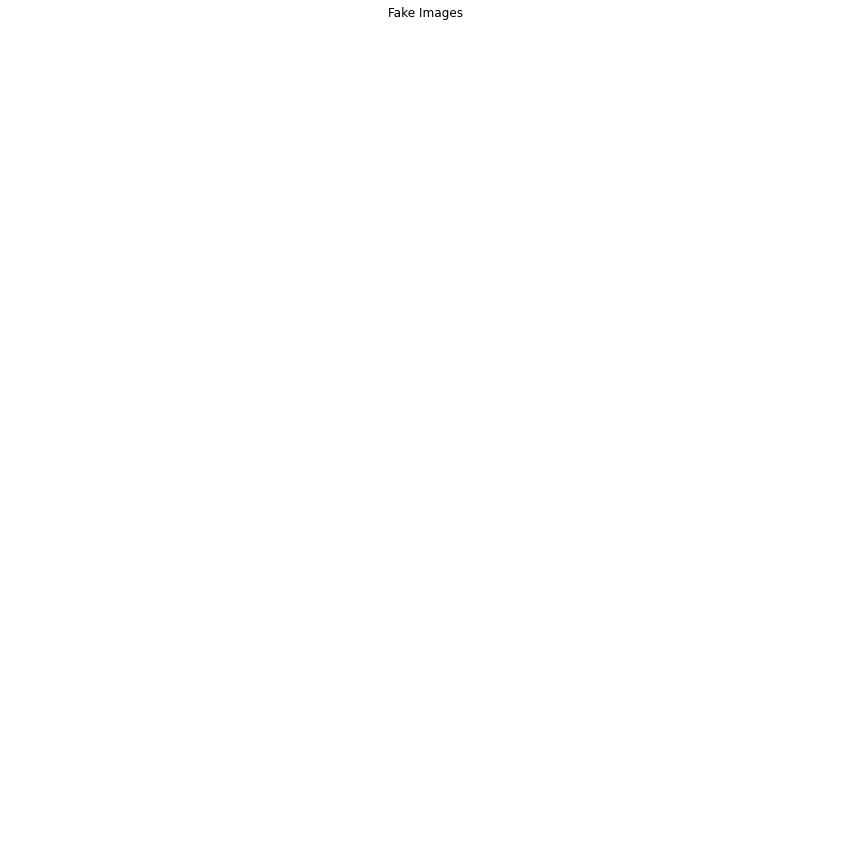

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(2,2,2)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[30],(1,2,0)))
plt.show()